In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Runnning on {device}')

transform = transforms.ToTensor()

train_dset = torchvision.datasets.MNIST('../', train=True, transform=transform, target_transform=None, download=False)
test_dset = torchvision.datasets.MNIST('../', train=False, transform=transform, target_transform=None, download=False)

train_dl = torch.utils.data.DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=1) 


Runnning on cpu


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 10)


    def forward(self, x):
        x = x.reshape(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x


In [9]:
net = Net()
net.to(device);

In [10]:
def lr_find(model, dataloader,criterion, start = 1e-10, stop = 1):
    lr_data = {'lr':[],'loss':[]}
    steps = len(dataloader)
    optimizer = optim.SGD(model.parameters(), lr=start, momentum=0.9)
    mult = np.exp(np.log(stop/start)/steps) # multiplicative exponent   
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: mult)
    
    for i,(inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        model.train() 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        lr_data['loss'].append(loss.item())   
        for param_group in optimizer.param_groups:
            lr_data['lr'].append(param_group['lr'])
            
        scheduler.step()

    return lr_data        

In [13]:
criterion = nn.CrossEntropyLoss()
lr_data = pd.DataFrame(lr_find(net, train_dl, criterion))

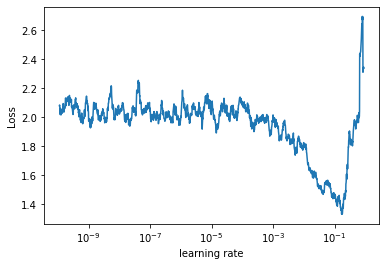

In [16]:
plt.semilogx(lr_data['lr'].rolling(20).mean(),lr_data['loss'].rolling(20).mean())
plt.xlabel('learning rate')
plt.ylabel('Loss')
plt.show()

Good rule of thumb is to pick a point a factor of 10 higher than the minimum. Since the minimum is around $10^{-1}$, a learnig rate of $10^{-2}$ would probably do pretty well. See https://fastai1.fast.ai/callbacks.lr_finder.html